# Configurando o Ambiente

- O dataset `output_df` é o resultado do nosso pipeline implementado através de modularização. Nele, realizamos a extração dos dados de consumo e dados externos, aplicando as transformações necessárias e unificando ambos em um único dataset. O pipeline é encontrado na pasta src-pipelines-Pipeline_etl do nosso github

- Para ler o arquivo em parquet, será utilizado dask pela praticidade na leitura

In [1]:
!pip install dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [2]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.8 MB/s eta 0:00:00


In [3]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, LSTM, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (roc_curve, auc, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             ConfusionMatrixDisplay, matthews_corrcoef)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.cluster import DBSCAN


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
output_df = dd.read_parquet("/content/drive/Shareddrives/AEGEA/DADOS/output/final_dataset.parquet")

In [ ]:
output_df.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,...,Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado,quantidade_shows,valor_IGPM,valor_SELIC,ano,valor_IPCA
0,2023-01-01,17089633,309250.0,31.0,0.0,Consumo Fixo,COMERCIAL,COMERCIAL,0.0,0.0,...,10.309677,299.032258,22.0,8.0,1.0,NaN,0.21,0.050788,2023.0,0.53
1,2023-12-01,17516238,210259.0,31.0,0.0,Consumo Fixo,RESIDENCIAL,RESIDENCIAL,0.0,0.0,...,9.512903,138.548387,20.0,10.0,1.0,1.0,0.74,0.045513,2023.0,0.56
2,2023-12-01,17516238,210259.0,31.0,0.0,Consumo Fixo,RESIDENCIAL,RESIDENCIAL,0.0,0.0,...,9.512903,138.548387,20.0,10.0,1.0,1.0,0.74,0.043739,2023.0,0.56
3,2023-10-01,17090191,1247377.0,32.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,...,11.738710,257.709677,20.0,9.0,2.0,NaN,0.50,0.047279,2023.0,0.24
4,2023-08-01,17314996,598695.0,32.0,75.0,Hidrometrado,COMERCIAL,COMERCIAL,-40.0,0.0,...,9.445161,177.064516,23.0,8.0,0.0,1.0,-0.14,0.050788,2023.0,0.23


In [ ]:
pd.set_option('display.max_columns', None)

# Resumindo os Dados em Trimestres

## Por que resumir em trimestres?

Considerando que estamos lidando com dados temporais e que é necessário entender padrões de consumo e possíveis fraudes a médio prazo, a agregação dos dados por trimestres pode proporcionar um desempenho analítico superior em comparação com o uso de intervalos de tempo mais longos, como seis meses.

## O que será feito?

- **Filtragem:** Limitar o conjunto de dados às matrículas que possuem o ano de 2022 completo.
- **Transformação:** Converter o DataFrame em uma tabela dinâmica (pivot) onde cada linha representa um trimestre.
- **Ordenação:** Ordenar os dados por matrícula e mês para facilitar a análise cronológica.


In [ ]:
df = output_df.compute()

In [ ]:
df.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,Temperature (°C),Precipitation (mm),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado,quantidade_shows,valor_IGPM,valor_SELIC,ano,valor_IPCA
0,2023-01-01,17089633,309250.0,31.0,0.0,Consumo Fixo,COMERCIAL,COMERCIAL,0.0,0.0,None,Normal,-20.459359,-54.604419,01/23,None,0,26.722581,0.0,10.309677,299.032258,22.0,8.0,1.0,NaN,0.21,0.050788,2023.0,0.53
1,2023-12-01,17516238,210259.0,31.0,0.0,Consumo Fixo,RESIDENCIAL,RESIDENCIAL,0.0,0.0,None,Normal,-20.387016,-54.551981,12/23,None,0,29.170968,0.0,9.512903,138.548387,20.0,10.0,1.0,1.0,0.74,0.045513,2023.0,0.56
2,2023-12-01,17516238,210259.0,31.0,0.0,Consumo Fixo,RESIDENCIAL,RESIDENCIAL,0.0,0.0,None,Normal,-20.387016,-54.551981,12/23,None,0,29.170968,0.0,9.512903,138.548387,20.0,10.0,1.0,1.0,0.74,0.043739,2023.0,0.56
3,2023-10-01,17090191,1247377.0,32.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,None,Normal,-20.453767,-54.596977,10/23,None,0,30.000000,0.0,11.738710,257.709677,20.0,9.0,2.0,NaN,0.50,0.047279,2023.0,0.24
4,2023-08-01,17314996,598695.0,32.0,75.0,Hidrometrado,COMERCIAL,COMERCIAL,-40.0,0.0,None,Normal,-20.490852,-54.627908,08/23,None,0,26.048387,0.0,9.445161,177.064516,23.0,8.0,0.0,1.0,-0.14,0.050788,2023.0,0.23


In [ ]:
df = df[['MATRICULA', 'REFERENCIA', 'CONS_MEDIDO', 'valor_SELIC', 'valor_IPCA',
       'valor_IGPM', 'Temperature (°C)', 'Wind Speed (km/h)',
       'Wind Direction (°)', 'tipo_dia_dia_util', 'tipo_dia_feriado',
       'tipo_dia_fim_de_semana', 'quantidade_shows', 'FRAUDE', 'ano', 'CATEGORIA', 'COD_LATITUDE', 'COD_LONGITUDE']]

In [ ]:
# 1. Filtrar Dados de 2021
def filtrar_ano(df, ano):
  df_filtrado = df[df['ano'] >= ano]
  return df_filtrado
df_2022 = filtrar_ano(df, 2022)

In [ ]:
df_2022['MES'] = df_2022['REFERENCIA'].dt.month

<ipython-input-11-891a730c0c47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['MES'] = df_2022['REFERENCIA'].dt.month


In [ ]:
df_2022 = df_2022[(df_2022['ano'] >= 2022) & (df_2022['ano'] < 2024)]

In [ ]:
df_2022['REFERENCIA'].min()

Timestamp('2022-01-01 00:00:00')

In [ ]:
def dois_anos_completos(grupo):
    anos = grupo['ano'].unique()
    # Verifica se há exatamente dois anos diferentes
    if len(anos) == 2:
        # Verifica se ambos os anos têm todos os meses de 1 a 12
        return all(grupo[grupo['ano'] == ano]['MES'].isin(range(1, 13)).all() for ano in anos)
    return False

# Aplicando a função para filtrar matriculas com dois anos completos
matriculas_completos = df_2022.groupby('MATRICULA').apply(dois_anos_completos)

# Filtrando apenas as matriculas com dois anos completos
matriculas_completos = matriculas_completos[matriculas_completos].index

print("Matrículas com dois anos completos (todos os meses de 1 a 12 em dois anos):")
print(matriculas_completos)
print(f"Quantidade de matrículas: {len(matriculas_completos)}")

# Filtrando o DataFrame original para manter apenas essas matrículas
dados_completos = df_2022[df_2022['MATRICULA'].isin(matriculas_completos)]
# Visualizando o resultado
dados_completos.head()

Matrículas com dois anos completos (todos os meses de 1 a 12 em dois anos):
Index(['17000001', '17075331', '17075333', '17075335', '17075336', '17075337',
       '17075338', '1707534', '17075341', '17075342',
       ...
       '17985441', '17985442', '17985443', '17985458', '17985459', '1798546',
       '17985461', '17985468', '1798557', '17985573'],
      dtype='object', name='MATRICULA', length=377454)
Quantidade de matrículas: 377454


,MATRICULA,REFERENCIA,CONS_MEDIDO,valor_SELIC,valor_IPCA,valor_IGPM,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_feriado,tipo_dia_fim_de_semana,quantidade_shows,FRAUDE,ano,CATEGORIA,COD_LATITUDE,COD_LONGITUDE,MES
0,17089633,2023-01-01,0.0,0.050788,0.53,0.21,26.722581,10.309677,299.032258,22.0,1.0,8.0,NaN,0,2023.0,COMERCIAL,-20.459359,-54.604419,1
1,17516238,2023-12-01,0.0,0.045513,0.56,0.74,29.170968,9.512903,138.548387,20.0,1.0,10.0,1.0,0,2023.0,RESIDENCIAL,-20.387016,-54.551981,12
2,17516238,2023-12-01,0.0,0.043739,0.56,0.74,29.170968,9.512903,138.548387,20.0,1.0,10.0,1.0,0,2023.0,RESIDENCIAL,-20.387016,-54.551981,12
3,17090191,2023-10-01,0.0,0.047279,0.24,0.50,30.000000,11.738710,257.709677,20.0,2.0,9.0,NaN,0,2023.0,RESIDENCIAL,-20.453767,-54.596977,10
4,17314996,2023-08-01,75.0,0.050788,0.23,-0.14,26.048387,9.445161,177.064516,23.0,0.0,8.0,1.0,0,2023.0,COMERCIAL,-20.490852,-54.627908,8


In [ ]:
# Preenchendo nulos da coluna shows para evitar futuros problemas
dados_completos['quantidade_shows'].fillna(0, inplace=True)

In [ ]:
# Dropar MATRICULA E REFERENCIA Duplicadas se existir por causa da selic
dados_completos = dados_completos.drop_duplicates(subset=['MATRICULA', 'REFERENCIA'])

In [ ]:
len(dados_completos['MATRICULA'].unique())

377454

In [ ]:
# Garantir que REFERENCIA esteja no formato datetime
dados_completos['REFERENCIA'] = pd.to_datetime(dados_completos['REFERENCIA'])

# Adicionando coluna de trimestre
dados_completos['TRIMESTRE'] = dados_completos['REFERENCIA'].dt.to_period('Q')

# Criando um identificador de trimestre sequencial
# Ordenar dados antes de criar o índice sequencial
dados_completos = dados_completos.sort_values(by=['MATRICULA', 'REFERENCIA'])

# Calcular o número de trimestres completos desde o início
dados_completos['SEQ_TRIMESTRE'] = dados_completos.groupby('MATRICULA').cumcount() // 3 + 1

# Substituir a coluna TRIMESTRE pelo índice sequencial no formato 'Q1', 'Q2', ...
dados_completos['TRIMESTRE_SEQUENCIAL'] = 'Q' + dados_completos['SEQ_TRIMESTRE'].astype(str)

# Lista de variáveis para criar colunas relativas (excluindo FRAUDE)
variaveis = ['CONS_MEDIDO', 'valor_SELIC', 'valor_IPCA', 'valor_IGPM', 'Temperature (°C)',
             'Wind Speed (km/h)', 'Wind Direction (°)', 'tipo_dia_dia_util', 'tipo_dia_feriado',
             'tipo_dia_fim_de_semana', 'quantidade_shows']

# Criando colunas relativas para cada variável
for var in variaveis:
    dados_completos[f'M0_{var}'] = dados_completos[var]
    dados_completos[f'M1_{var}'] = dados_completos.groupby('MATRICULA')[var].shift(-1)
    dados_completos[f'M2_{var}'] = dados_completos.groupby('MATRICULA')[var].shift(-2)

# Selecionando as colunas relativas para a pivot table
colunas_relativas = [f'M{i}_{var}' for var in variaveis for i in range(3)]

# Adicionando coluna FRAUDE que indica se houve fraude no período
dados_completos['FRAUDE_TRIMESTRE'] = dados_completos.groupby(['MATRICULA', 'TRIMESTRE_SEQUENCIAL'])['FRAUDE'].transform('max')

# Adicionando CATEGORIA, COD_LATITUDE e COD_LONGITUDE para a pivot table
constantes = ['CATEGORIA', 'COD_LATITUDE', 'COD_LONGITUDE']

# Pivot table trimestral com colunas relativas, FRAUDE_TRIMESTRE e constantes
pivot_df = dados_completos.pivot_table(
    index=['MATRICULA', 'TRIMESTRE_SEQUENCIAL'],
    values=colunas_relativas + ['FRAUDE_TRIMESTRE'] + constantes,
    aggfunc='first'  # Como essas variáveis são constantes, 'first' funciona para manter o valor
).reset_index()

# Visualizando os resultados
pivot_df.head()

# Lista das variáveis a serem agregadas (sem os prefixos M0, M1, M2)
variaveis_base = ['CONS_MEDIDO', 'valor_SELIC', 'valor_IPCA', 'valor_IGPM',
                  'Temperature (°C)', 'Wind Speed (km/h)', 'Wind Direction (°)',
                  'tipo_dia_dia_util', 'tipo_dia_feriado', 'tipo_dia_fim_de_semana',
                  'quantidade_shows']

# Criar um DataFrame final para consolidar as informações trimestrais
df_consolidado = pd.DataFrame()

# Iterar por cada trimestre único no DataFrame pivot_df
for trimestre in pivot_df['TRIMESTRE_SEQUENCIAL'].unique():
    # Filtrar o DataFrame para o trimestre específico
    df_trimestre = pivot_df[pivot_df['TRIMESTRE_SEQUENCIAL'] == trimestre]

    # Criar um dicionário de agregação
    agregacoes = {}
    for var in variaveis_base:
        # Agregar a média e desvio padrão das variáveis relativas
        agregacoes[f'{var}_{trimestre}_MEAN'] = df_trimestre[[f'M0_{var}', f'M1_{var}', f'M2_{var}']].mean(axis=1)
        agregacoes[f'{var}_{trimestre}_STD'] = df_trimestre[[f'M0_{var}', f'M1_{var}', f'M2_{var}']].std(axis=1)

    # Adicionar a coluna de fraude do trimestre
    agregacoes[f'FRAUDE_{trimestre}'] = df_trimestre['FRAUDE_TRIMESTRE']

    # Criar DataFrame temporário com as agregações para o trimestre atual
    # Incluir constantes ao df_temp
    df_temp = df_trimestre[['MATRICULA', 'CATEGORIA', 'COD_LATITUDE', 'COD_LONGITUDE']].copy()
    for key, value in agregacoes.items():
        df_temp[key] = value

    # Mesclar o DataFrame temporário ao consolidado
    if df_consolidado.empty:
        df_consolidado = df_temp
    else:
        df_consolidado = pd.merge(df_consolidado, df_temp, on=['MATRICULA', 'CATEGORIA', 'COD_LATITUDE', 'COD_LONGITUDE'], how='outer')

# Exibir o DataFrame consolidado final
df_consolidado.head()


,MATRICULA,CATEGORIA,COD_LATITUDE,COD_LONGITUDE,CONS_MEDIDO_Q1_MEAN,CONS_MEDIDO_Q1_STD,valor_SELIC_Q1_MEAN,valor_SELIC_Q1_STD,valor_IPCA_Q1_MEAN,valor_IPCA_Q1_STD,valor_IGPM_Q1_MEAN,valor_IGPM_Q1_STD,Temperature (°C)_Q1_MEAN,Temperature (°C)_Q1_STD,Wind Speed (km/h)_Q1_MEAN,Wind Speed (km/h)_Q1_STD,Wind Direction (°)_Q1_MEAN,Wind Direction (°)_Q1_STD,tipo_dia_dia_util_Q1_MEAN,tipo_dia_dia_util_Q1_STD,tipo_dia_feriado_Q1_MEAN,tipo_dia_feriado_Q1_STD,tipo_dia_fim_de_semana_Q1_MEAN,tipo_dia_fim_de_semana_Q1_STD,quantidade_shows_Q1_MEAN,quantidade_shows_Q1_STD,FRAUDE_Q1,CONS_MEDIDO_Q2_MEAN,CONS_MEDIDO_Q2_STD,valor_SELIC_Q2_MEAN,valor_SELIC_Q2_STD,valor_IPCA_Q2_MEAN,valor_IPCA_Q2_STD,valor_IGPM_Q2_MEAN,valor_IGPM_Q2_STD,Temperature (°C)_Q2_MEAN,Temperature (°C)_Q2_STD,Wind Speed (km/h)_Q2_MEAN,Wind Speed (km/h)_Q2_STD,Wind Direction (°)_Q2_MEAN,Wind Direction (°)_Q2_STD,tipo_dia_dia_util_Q2_MEAN,tipo_dia_dia_util_Q2_STD,tipo_dia_feriado_Q2_MEAN,tipo_dia_feriado_Q2_STD,tipo_dia_fim_de_semana_Q2_MEAN,tipo_dia_fim_de_semana_Q2_STD,quantidade_shows_Q2_MEAN,quantidade_shows_Q2_STD,FRAUDE_Q2,CONS_MEDIDO_Q3_MEAN,CONS_MEDIDO_Q3_STD,valor_SELIC_Q3_MEAN,valor_SELIC_Q3_STD,valor_IPCA_Q3_MEAN,valor_IPCA_Q3_STD,valor_IGPM_Q3_MEAN,valor_IGPM_Q3_STD,Temperature (°C)_Q3_MEAN,Temperature (°C)_Q3_STD,Wind Speed (km/h)_Q3_MEAN,Wind Speed (km/h)_Q3_STD,Wind Direction (°)_Q3_MEAN,Wind Direction (°)_Q3_STD,tipo_dia_dia_util_Q3_MEAN,tipo_dia_dia_util_Q3_STD,tipo_dia_feriado_Q3_MEAN,tipo_dia_feriado_Q3_STD,tipo_dia_fim_de_semana_Q3_MEAN,tipo_dia_fim_de_semana_Q3_STD,quantidade_shows_Q3_MEAN,quantidade_shows_Q3_STD,FRAUDE_Q3,CONS_MEDIDO_Q4_MEAN,CONS_MEDIDO_Q4_STD,valor_SELIC_Q4_MEAN,valor_SELIC_Q4_STD,valor_IPCA_Q4_MEAN,valor_IPCA_Q4_STD,valor_IGPM_Q4_MEAN,valor_IGPM_Q4_STD,Temperature (°C)_Q4_MEAN,Temperature (°C)_Q4_STD,Wind Speed (km/h)_Q4_MEAN,Wind Speed (km/h)_Q4_STD,Wind Direction (°)_Q4_MEAN,Wind Direction (°)_Q4_STD,tipo_dia_dia_util_Q4_MEAN,tipo_dia_dia_util_Q4_STD,tipo_dia_feriado_Q4_MEAN,tipo_dia_feriado_Q4_STD,tipo_dia_fim_de_semana_Q4_MEAN,tipo_dia_fim_de_semana_Q4_STD,quantidade_shows_Q4_MEAN,quantidade_shows_Q4_STD,FRAUDE_Q4,CONS_MEDIDO_Q5_MEAN,CONS_MEDIDO_Q5_STD,valor_SELIC_Q5_MEAN,valor_SELIC_Q5_STD,valor_IPCA_Q5_MEAN,valor_IPCA_Q5_STD,valor_IGPM_Q5_MEAN,valor_IGPM_Q5_STD,Temperature (°C)_Q5_MEAN,Temperature (°C)_Q5_STD,Wind Speed (km/h)_Q5_MEAN,Wind Speed (km/h)_Q5_STD,Wind Direction (°)_Q5_MEAN,Wind Direction (°)_Q5_STD,tipo_dia_dia_util_Q5_MEAN,tipo_dia_dia_util_Q5_STD,tipo_dia_feriado_Q5_MEAN,tipo_dia_feriado_Q5_STD,tipo_dia_fim_de_semana_Q5_MEAN,tipo_dia_fim_de_semana_Q5_STD,quantidade_shows_Q5_MEAN,quantidade_shows_Q5_STD,FRAUDE_Q5,CONS_MEDIDO_Q6_MEAN,CONS_MEDIDO_Q6_STD,valor_SELIC_Q6_MEAN,valor_SELIC_Q6_STD,valor_IPCA_Q6_MEAN,valor_IPCA_Q6_STD,valor_IGPM_Q6_MEAN,valor_IGPM_Q6_STD,Temperature (°C)_Q6_MEAN,Temperature (°C)_Q6_STD,Wind Speed (km/h)_Q6_MEAN,Wind Speed (km/h)_Q6_STD,Wind Direction (°)_Q6_MEAN,Wind Direction (°)_Q6_STD,tipo_dia_dia_util_Q6_MEAN,tipo_dia_dia_util_Q6_STD,tipo_dia_feriado_Q6_MEAN,tipo_dia_feriado_Q6_STD,tipo_dia_fim_de_semana_Q6_MEAN,tipo_dia_fim_de_semana_Q6_STD,quantidade_shows_Q6_MEAN,quantidade_shows_Q6_STD,FRAUDE_Q6,CONS_MEDIDO_Q7_MEAN,CONS_MEDIDO_Q7_STD,valor_SELIC_Q7_MEAN,valor_SELIC_Q7_STD,valor_IPCA_Q7_MEAN,valor_IPCA_Q7_STD,valor_IGPM_Q7_MEAN,valor_IGPM_Q7_STD,Temperature (°C)_Q7_MEAN,Temperature (°C)_Q7_STD,Wind Speed (km/h)_Q7_MEAN,Wind Speed (km/h)_Q7_STD,Wind Direction (°)_Q7_MEAN,Wind Direction (°)_Q7_STD,tipo_dia_dia_util_Q7_MEAN,tipo_dia_dia_util_Q7_STD,tipo_dia_feriado_Q7_MEAN,tipo_dia_feriado_Q7_STD,tipo_dia_fim_de_semana_Q7_MEAN,tipo_dia_fim_de_semana_Q7_STD,quantidade_shows_Q7_MEAN,quantidade_shows_Q7_STD,FRAUDE_Q7,CONS_MEDIDO_Q8_MEAN,CONS_MEDIDO_Q8_STD,valor_SELIC_Q8_MEAN,valor_SELIC_Q8_STD,valor_IPCA_Q8_MEAN,valor_IPCA_Q8_STD,valor_IGPM_Q8_MEAN,valor_IGPM_Q8_STD,Temperature (°C)_Q8_MEAN,Temperature (°C)_Q8_STD,Wind Speed (km/h)_Q8_MEAN,Wind Speed (km/h)_Q8_STD,Wind Direction (°)_Q8_MEA

In [ ]:
df_consolidado.fillna(0, inplace=True)

In [ ]:
# Load na tabela
df_consolidado.to_parquet("/content/drive/Shareddrives/AEGEA/DADOS/output/pivot_df.parquet")

In [11]:
df_consolidado = pd.read_parquet("/content/drive/Shareddrives/AEGEA/DADOS/output/pivot_df.parquet")

# Estruturando os dados para treino
## Porque Estruturar os dados para o treino?
Para que seja possível treinar em uma LSTM é necessário que os dados seja organizados com uma sequência temporal das matriculas em matrizes explícitas.
Além, disso para que o modelo possua suas métricas de desempenho é imprecindível ter uma porcentagem dos dados como teste.

## O que será feito?
- **Label Encoding**: Transformar em números, dados categóricos
- **Clusterização:**: Clusterizar com base na latitude e longitude
- **Balanceamento**: Balanceamento utilizando RandomUnderSampling
- **Normalização**: Normalização utilizando RobustScaler
- **Estruturação**: Função para estrutura sequência dos dados

## Label Encoding
### Porque o Label Encoding?
Para que seja possível que o modelo entenda dados em formato de string, como por exemplo dados categóricos, é necessário transforma-los em dados numéricos
### O que será feito?
- **Label Encoding**: Aplicação da função de pré-processamento Label Encoding

In [12]:
# Label enconding para a coluna Categoria
le = LabelEncoder()
df_consolidado['CATEGORIA'] = le.fit_transform(df_consolidado['CATEGORIA'])

## Encoding Cíclico para Coordenadas Geográficas
### Porque o Encoding Cíclico para Coordenadas Geográficas?
Para que seja possível que o modelo entenda os dados geográficos de latitude e longitude, é necessário transforma-los de uma forma que o modelo entenda
### O que será feito?
- **Encoding Cíclico para Coordenadas Geográficas**: Transformação da coordenadas em radianos

In [13]:
def encoding_ciclico(df, col_lat='COD_LATITUDE', col_lon='COD_LONGITUDE'):
    # Converter graus para radianos
    df['lat_rad'] = np.radians(df[col_lat])
    df['lon_rad'] = np.radians(df[col_lon])

    # Aplicar funções seno e cosseno
    df['lat_sin'] = np.sin(df['lat_rad'])
    df['lat_cos'] = np.cos(df['lat_rad'])
    df['lon_sin'] = np.sin(df['lon_rad'])
    df['lon_cos'] = np.cos(df['lon_rad'])

    # Normalizar as novas features
    scaler = MinMaxScaler()
    cols_to_scale = ['lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    # Remover colunas intermediárias
    df.drop(['lat_rad', 'lon_rad'], axis=1, inplace=True)

    return df
df_consolidado = encoding_ciclico(df_consolidado)
print(df_consolidado)


       MATRICULA  CATEGORIA  COD_LATITUDE  COD_LONGITUDE  CONS_MEDIDO_Q1_MEAN  \
0       17000001          3    -20.527506     -54.604682             7.666667   
1       17075331          0    -20.452847     -54.599802            10.333333   
2       17075333          0    -20.452863     -54.599894             0.000000   
3       17075335          0    -20.452938     -54.600345             3.333333   
4       17075336          3    -20.452967     -54.600516             0.000000   
...          ...        ...           ...            ...                  ...   
391733  17978278          0    -20.542977     -54.582879             0.000000   
391734  17978782          0    -20.491539     -54.611504             0.000000   
391735  17978924          0    -20.460745     -54.536658             0.000000   
391736  17979244          0    -20.430870     -54.570698             0.000000   
391737  17979365          0    -20.536570     -54.637954             0.000000   

        CONS_MEDIDO_Q1_STD 

## Balanceamento
### Porque o Balanceamento?
Há um número imenso de não fraudes a mais, o que potencializa o modelo a chutar tudo como não fraude, o que resultaria em uma acurácia falsa.
### O que será feito?
- **SMOTE + undersampling**: Equilibra a relação entre as classes de fraude e não fraude, sem gerar uma quantidade excessiva de dados sintéticos ou ignorar dados relevantes da classe majoritária.

In [14]:
df_consolidado.head()

,MATRICULA,CATEGORIA,COD_LATITUDE,COD_LONGITUDE,CONS_MEDIDO_Q1_MEAN,CONS_MEDIDO_Q1_STD,valor_SELIC_Q1_MEAN,valor_SELIC_Q1_STD,valor_IPCA_Q1_MEAN,valor_IPCA_Q1_STD,valor_IGPM_Q1_MEAN,valor_IGPM_Q1_STD,Temperature (°C)_Q1_MEAN,Temperature (°C)_Q1_STD,Wind Speed (km/h)_Q1_MEAN,Wind Speed (km/h)_Q1_STD,Wind Direction (°)_Q1_MEAN,Wind Direction (°)_Q1_STD,tipo_dia_dia_util_Q1_MEAN,tipo_dia_dia_util_Q1_STD,tipo_dia_feriado_Q1_MEAN,tipo_dia_feriado_Q1_STD,tipo_dia_fim_de_semana_Q1_MEAN,tipo_dia_fim_de_semana_Q1_STD,quantidade_shows_Q1_MEAN,quantidade_shows_Q1_STD,FRAUDE_Q1,CONS_MEDIDO_Q2_MEAN,CONS_MEDIDO_Q2_STD,valor_SELIC_Q2_MEAN,valor_SELIC_Q2_STD,valor_IPCA_Q2_MEAN,valor_IPCA_Q2_STD,valor_IGPM_Q2_MEAN,valor_IGPM_Q2_STD,Temperature (°C)_Q2_MEAN,Temperature (°C)_Q2_STD,Wind Speed (km/h)_Q2_MEAN,Wind Speed (km/h)_Q2_STD,Wind Direction (°)_Q2_MEAN,Wind Direction (°)_Q2_STD,tipo_dia_dia_util_Q2_MEAN,tipo_dia_dia_util_Q2_STD,tipo_dia_feriado_Q2_MEAN,tipo_dia_feriado_Q2_STD,tipo_dia_fim_de_semana_Q2_MEAN,tipo_dia_fim_de_semana_Q2_STD,quantidade_shows_Q2_MEAN,quantidade_shows_Q2_STD,FRAUDE_Q2,CONS_MEDIDO_Q3_MEAN,CONS_MEDIDO_Q3_STD,valor_SELIC_Q3_MEAN,valor_SELIC_Q3_STD,valor_IPCA_Q3_MEAN,valor_IPCA_Q3_STD,valor_IGPM_Q3_MEAN,valor_IGPM_Q3_STD,Temperature (°C)_Q3_MEAN,Temperature (°C)_Q3_STD,Wind Speed (km/h)_Q3_MEAN,Wind Speed (km/h)_Q3_STD,Wind Direction (°)_Q3_MEAN,Wind Direction (°)_Q3_STD,tipo_dia_dia_util_Q3_MEAN,tipo_dia_dia_util_Q3_STD,tipo_dia_feriado_Q3_MEAN,tipo_dia_feriado_Q3_STD,tipo_dia_fim_de_semana_Q3_MEAN,tipo_dia_fim_de_semana_Q3_STD,quantidade_shows_Q3_MEAN,quantidade_shows_Q3_STD,FRAUDE_Q3,CONS_MEDIDO_Q4_MEAN,CONS_MEDIDO_Q4_STD,valor_SELIC_Q4_MEAN,valor_SELIC_Q4_STD,valor_IPCA_Q4_MEAN,valor_IPCA_Q4_STD,valor_IGPM_Q4_MEAN,valor_IGPM_Q4_STD,Temperature (°C)_Q4_MEAN,Temperature (°C)_Q4_STD,Wind Speed (km/h)_Q4_MEAN,Wind Speed (km/h)_Q4_STD,Wind Direction (°)_Q4_MEAN,Wind Direction (°)_Q4_STD,tipo_dia_dia_util_Q4_MEAN,tipo_dia_dia_util_Q4_STD,tipo_dia_feriado_Q4_MEAN,tipo_dia_feriado_Q4_STD,tipo_dia_fim_de_semana_Q4_MEAN,tipo_dia_fim_de_semana_Q4_STD,quantidade_shows_Q4_MEAN,quantidade_shows_Q4_STD,FRAUDE_Q4,CONS_MEDIDO_Q5_MEAN,CONS_MEDIDO_Q5_STD,valor_SELIC_Q5_MEAN,valor_SELIC_Q5_STD,valor_IPCA_Q5_MEAN,valor_IPCA_Q5_STD,valor_IGPM_Q5_MEAN,valor_IGPM_Q5_STD,Temperature (°C)_Q5_MEAN,Temperature (°C)_Q5_STD,Wind Speed (km/h)_Q5_MEAN,Wind Speed (km/h)_Q5_STD,Wind Direction (°)_Q5_MEAN,Wind Direction (°)_Q5_STD,tipo_dia_dia_util_Q5_MEAN,tipo_dia_dia_util_Q5_STD,tipo_dia_feriado_Q5_MEAN,tipo_dia_feriado_Q5_STD,tipo_dia_fim_de_semana_Q5_MEAN,tipo_dia_fim_de_semana_Q5_STD,quantidade_shows_Q5_MEAN,quantidade_shows_Q5_STD,FRAUDE_Q5,CONS_MEDIDO_Q6_MEAN,CONS_MEDIDO_Q6_STD,valor_SELIC_Q6_MEAN,valor_SELIC_Q6_STD,valor_IPCA_Q6_MEAN,valor_IPCA_Q6_STD,valor_IGPM_Q6_MEAN,valor_IGPM_Q6_STD,Temperature (°C)_Q6_MEAN,Temperature (°C)_Q6_STD,Wind Speed (km/h)_Q6_MEAN,Wind Speed (km/h)_Q6_STD,Wind Direction (°)_Q6_MEAN,Wind Direction (°)_Q6_STD,tipo_dia_dia_util_Q6_MEAN,tipo_dia_dia_util_Q6_STD,tipo_dia_feriado_Q6_MEAN,tipo_dia_feriado_Q6_STD,tipo_dia_fim_de_semana_Q6_MEAN,tipo_dia_fim_de_semana_Q6_STD,quantidade_shows_Q6_MEAN,quantidade_shows_Q6_STD,FRAUDE_Q6,CONS_MEDIDO_Q7_MEAN,CONS_MEDIDO_Q7_STD,valor_SELIC_Q7_MEAN,valor_SELIC_Q7_STD,valor_IPCA_Q7_MEAN,valor_IPCA_Q7_STD,valor_IGPM_Q7_MEAN,valor_IGPM_Q7_STD,Temperature (°C)_Q7_MEAN,Temperature (°C)_Q7_STD,Wind Speed (km/h)_Q7_MEAN,Wind Speed (km/h)_Q7_STD,Wind Direction (°)_Q7_MEAN,Wind Direction (°)_Q7_STD,tipo_dia_dia_util_Q7_MEAN,tipo_dia_dia_util_Q7_STD,tipo_dia_feriado_Q7_MEAN,tipo_dia_feriado_Q7_STD,tipo_dia_fim_de_semana_Q7_MEAN,tipo_dia_fim_de_semana_Q7_STD,quantidade_shows_Q7_MEAN,quantidade_shows_Q7_STD,FRAUDE_Q7,CONS_MEDIDO_Q8_MEAN,CONS_MEDIDO_Q8_STD,valor_SELIC_Q8_MEAN,valor_SELIC_Q8_STD,valor_IPCA_Q8_MEAN,valor_IPCA_Q8_STD,valor_IGPM_Q8_MEAN,valor_IGPM_Q8_STD,Temperature (°C)_Q8_MEAN,Temperature (°C)_Q8_STD,Wind Speed (km/h)_Q8_MEAN,Wind Speed (km/h)_Q8_STD,Wind Direction (°)_Q8_MEA

In [15]:
pd.set_option('display.max_columns', None)

In [16]:
df_consolidado.head()

,MATRICULA,CATEGORIA,COD_LATITUDE,COD_LONGITUDE,CONS_MEDIDO_Q1_MEAN,CONS_MEDIDO_Q1_STD,valor_SELIC_Q1_MEAN,valor_SELIC_Q1_STD,valor_IPCA_Q1_MEAN,valor_IPCA_Q1_STD,valor_IGPM_Q1_MEAN,valor_IGPM_Q1_STD,Temperature (°C)_Q1_MEAN,Temperature (°C)_Q1_STD,Wind Speed (km/h)_Q1_MEAN,Wind Speed (km/h)_Q1_STD,Wind Direction (°)_Q1_MEAN,Wind Direction (°)_Q1_STD,tipo_dia_dia_util_Q1_MEAN,tipo_dia_dia_util_Q1_STD,tipo_dia_feriado_Q1_MEAN,tipo_dia_feriado_Q1_STD,tipo_dia_fim_de_semana_Q1_MEAN,tipo_dia_fim_de_semana_Q1_STD,quantidade_shows_Q1_MEAN,quantidade_shows_Q1_STD,FRAUDE_Q1,CONS_MEDIDO_Q2_MEAN,CONS_MEDIDO_Q2_STD,valor_SELIC_Q2_MEAN,valor_SELIC_Q2_STD,valor_IPCA_Q2_MEAN,valor_IPCA_Q2_STD,valor_IGPM_Q2_MEAN,valor_IGPM_Q2_STD,Temperature (°C)_Q2_MEAN,Temperature (°C)_Q2_STD,Wind Speed (km/h)_Q2_MEAN,Wind Speed (km/h)_Q2_STD,Wind Direction (°)_Q2_MEAN,Wind Direction (°)_Q2_STD,tipo_dia_dia_util_Q2_MEAN,tipo_dia_dia_util_Q2_STD,tipo_dia_feriado_Q2_MEAN,tipo_dia_feriado_Q2_STD,tipo_dia_fim_de_semana_Q2_MEAN,tipo_dia_fim_de_semana_Q2_STD,quantidade_shows_Q2_MEAN,quantidade_shows_Q2_STD,FRAUDE_Q2,CONS_MEDIDO_Q3_MEAN,CONS_MEDIDO_Q3_STD,valor_SELIC_Q3_MEAN,valor_SELIC_Q3_STD,valor_IPCA_Q3_MEAN,valor_IPCA_Q3_STD,valor_IGPM_Q3_MEAN,valor_IGPM_Q3_STD,Temperature (°C)_Q3_MEAN,Temperature (°C)_Q3_STD,Wind Speed (km/h)_Q3_MEAN,Wind Speed (km/h)_Q3_STD,Wind Direction (°)_Q3_MEAN,Wind Direction (°)_Q3_STD,tipo_dia_dia_util_Q3_MEAN,tipo_dia_dia_util_Q3_STD,tipo_dia_feriado_Q3_MEAN,tipo_dia_feriado_Q3_STD,tipo_dia_fim_de_semana_Q3_MEAN,tipo_dia_fim_de_semana_Q3_STD,quantidade_shows_Q3_MEAN,quantidade_shows_Q3_STD,FRAUDE_Q3,CONS_MEDIDO_Q4_MEAN,CONS_MEDIDO_Q4_STD,valor_SELIC_Q4_MEAN,valor_SELIC_Q4_STD,valor_IPCA_Q4_MEAN,valor_IPCA_Q4_STD,valor_IGPM_Q4_MEAN,valor_IGPM_Q4_STD,Temperature (°C)_Q4_MEAN,Temperature (°C)_Q4_STD,Wind Speed (km/h)_Q4_MEAN,Wind Speed (km/h)_Q4_STD,Wind Direction (°)_Q4_MEAN,Wind Direction (°)_Q4_STD,tipo_dia_dia_util_Q4_MEAN,tipo_dia_dia_util_Q4_STD,tipo_dia_feriado_Q4_MEAN,tipo_dia_feriado_Q4_STD,tipo_dia_fim_de_semana_Q4_MEAN,tipo_dia_fim_de_semana_Q4_STD,quantidade_shows_Q4_MEAN,quantidade_shows_Q4_STD,FRAUDE_Q4,CONS_MEDIDO_Q5_MEAN,CONS_MEDIDO_Q5_STD,valor_SELIC_Q5_MEAN,valor_SELIC_Q5_STD,valor_IPCA_Q5_MEAN,valor_IPCA_Q5_STD,valor_IGPM_Q5_MEAN,valor_IGPM_Q5_STD,Temperature (°C)_Q5_MEAN,Temperature (°C)_Q5_STD,Wind Speed (km/h)_Q5_MEAN,Wind Speed (km/h)_Q5_STD,Wind Direction (°)_Q5_MEAN,Wind Direction (°)_Q5_STD,tipo_dia_dia_util_Q5_MEAN,tipo_dia_dia_util_Q5_STD,tipo_dia_feriado_Q5_MEAN,tipo_dia_feriado_Q5_STD,tipo_dia_fim_de_semana_Q5_MEAN,tipo_dia_fim_de_semana_Q5_STD,quantidade_shows_Q5_MEAN,quantidade_shows_Q5_STD,FRAUDE_Q5,CONS_MEDIDO_Q6_MEAN,CONS_MEDIDO_Q6_STD,valor_SELIC_Q6_MEAN,valor_SELIC_Q6_STD,valor_IPCA_Q6_MEAN,valor_IPCA_Q6_STD,valor_IGPM_Q6_MEAN,valor_IGPM_Q6_STD,Temperature (°C)_Q6_MEAN,Temperature (°C)_Q6_STD,Wind Speed (km/h)_Q6_MEAN,Wind Speed (km/h)_Q6_STD,Wind Direction (°)_Q6_MEAN,Wind Direction (°)_Q6_STD,tipo_dia_dia_util_Q6_MEAN,tipo_dia_dia_util_Q6_STD,tipo_dia_feriado_Q6_MEAN,tipo_dia_feriado_Q6_STD,tipo_dia_fim_de_semana_Q6_MEAN,tipo_dia_fim_de_semana_Q6_STD,quantidade_shows_Q6_MEAN,quantidade_shows_Q6_STD,FRAUDE_Q6,CONS_MEDIDO_Q7_MEAN,CONS_MEDIDO_Q7_STD,valor_SELIC_Q7_MEAN,valor_SELIC_Q7_STD,valor_IPCA_Q7_MEAN,valor_IPCA_Q7_STD,valor_IGPM_Q7_MEAN,valor_IGPM_Q7_STD,Temperature (°C)_Q7_MEAN,Temperature (°C)_Q7_STD,Wind Speed (km/h)_Q7_MEAN,Wind Speed (km/h)_Q7_STD,Wind Direction (°)_Q7_MEAN,Wind Direction (°)_Q7_STD,tipo_dia_dia_util_Q7_MEAN,tipo_dia_dia_util_Q7_STD,tipo_dia_feriado_Q7_MEAN,tipo_dia_feriado_Q7_STD,tipo_dia_fim_de_semana_Q7_MEAN,tipo_dia_fim_de_semana_Q7_STD,quantidade_shows_Q7_MEAN,quantidade_shows_Q7_STD,FRAUDE_Q7,CONS_MEDIDO_Q8_MEAN,CONS_MEDIDO_Q8_STD,valor_SELIC_Q8_MEAN,valor_SELIC_Q8_STD,valor_IPCA_Q8_MEAN,valor_IPCA_Q8_STD,valor_IGPM_Q8_MEAN,valor_IGPM_Q8_STD,Temperature (°C)_Q8_MEAN,Temperature (°C)_Q8_STD,Wind Speed (km/h)_Q8_MEAN,Wind Speed (km/h)_Q8_STD,Wind Direction (°)_Q8_MEA

In [17]:
df_consolidado['FRAUDE_Q8'].value_counts()

,count
FRAUDE_Q8,
0.0,381201
1.0,10537


In [18]:
X = df_consolidado.drop(columns=['FRAUDE_Q8', 'COD_LATITUDE',	'COD_LONGITUDE', 'MATRICULA'], axis= 1)  # Features
y = df_consolidado['FRAUDE_Q8']  # Target

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar instâncias do SMOTE e do RandomUnderSampler
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Aumenta a classe minoritária para 50% da classe majoritária
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # Mantém uma proporção de 80% para classe majoritária

# Primeiro, faz o SMOTE no conjunto de treino
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Depois, faz o undersampling
X_balanced, y_balanced = undersample.fit_resample(X_smote, y_smote)

# Verificar o balanceamento
print(f"Distribuição após balanceamento: {y_balanced.value_counts()}")

Distribuição após balanceamento: FRAUDE_Q8
0.0    190605
1.0    152484
Name: count, dtype: int64


## Normalização
### Porque Normalização?
Como os dados apresentam escalas diferentes é necessário padronizar a escala deles para evitar que uma feature possa afetar o desempenho dos pesos do modelo por apenas ter uma escala maior ou menor que outra feature
### O que será feito?
- **Padronização**: Aplicar o Robust Scaler (Cálculo baseado nos outliers)

In [19]:
# Normalizar os dados (RobustScaler)
scaler = RobustScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)

## Divisão de Treino e Teste
###Porque Divisão dos dados?
Para que seja possível acompanhar o desempenho do modelo é preciso dividir o modelo entre os dados de treinamento e os dados de testes (dados não vistos pelo modelo). Para isso é preciso dividir uma porcentagem minoritária para os dados de teste
###O que será feito?
- **Divisão**: Aplicar divisão segmentada por treino e teste
- **Estruturação dos dados**: Aplicar uma estruturação para que o modelo receba dados trimestrais e fixos (categoria e geográficos)

In [20]:
# Definindo as features temporais para cada trimestre de Q1 a Q8
features_temporais = []
for q in range(1, 9):
    features_temporais.extend([
        f"CONS_MEDIDO_Q{q}_MEAN", f"CONS_MEDIDO_Q{q}_STD",
        f"valor_SELIC_Q{q}_MEAN", f"valor_SELIC_Q{q}_STD",
        f"valor_IPCA_Q{q}_MEAN", f"valor_IPCA_Q{q}_STD",
        f"valor_IGPM_Q{q}_MEAN", f"valor_IGPM_Q{q}_STD",
        f"Temperature (°C)_Q{q}_MEAN", f"Temperature (°C)_Q{q}_STD",
        f"Wind Speed (km/h)_Q{q}_MEAN", f"Wind Speed (km/h)_Q{q}_STD",
        f"Wind Direction (°)_Q{q}_MEAN", f"Wind Direction (°)_Q{q}_STD",
        f"tipo_dia_dia_util_Q{q}_MEAN", f"tipo_dia_dia_util_Q{q}_STD",
        f"tipo_dia_feriado_Q{q}_MEAN", f"tipo_dia_feriado_Q{q}_STD",
        f"tipo_dia_fim_de_semana_Q{q}_MEAN", f"tipo_dia_fim_de_semana_Q{q}_STD",
        f"quantidade_shows_Q{q}_MEAN", f"quantidade_shows_Q{q}_STD",
        f"FRAUDE_Q{q}"
    ])

# Exemplo de uso das features temporais
print(features_temporais)

['CONS_MEDIDO_Q1_MEAN', 'CONS_MEDIDO_Q1_STD', 'valor_SELIC_Q1_MEAN', 'valor_SELIC_Q1_STD', 'valor_IPCA_Q1_MEAN', 'valor_IPCA_Q1_STD', 'valor_IGPM_Q1_MEAN', 'valor_IGPM_Q1_STD', 'Temperature (°C)_Q1_MEAN', 'Temperature (°C)_Q1_STD', 'Wind Speed (km/h)_Q1_MEAN', 'Wind Speed (km/h)_Q1_STD', 'Wind Direction (°)_Q1_MEAN', 'Wind Direction (°)_Q1_STD', 'tipo_dia_dia_util_Q1_MEAN', 'tipo_dia_dia_util_Q1_STD', 'tipo_dia_feriado_Q1_MEAN', 'tipo_dia_feriado_Q1_STD', 'tipo_dia_fim_de_semana_Q1_MEAN', 'tipo_dia_fim_de_semana_Q1_STD', 'quantidade_shows_Q1_MEAN', 'quantidade_shows_Q1_STD', 'FRAUDE_Q1', 'CONS_MEDIDO_Q2_MEAN', 'CONS_MEDIDO_Q2_STD', 'valor_SELIC_Q2_MEAN', 'valor_SELIC_Q2_STD', 'valor_IPCA_Q2_MEAN', 'valor_IPCA_Q2_STD', 'valor_IGPM_Q2_MEAN', 'valor_IGPM_Q2_STD', 'Temperature (°C)_Q2_MEAN', 'Temperature (°C)_Q2_STD', 'Wind Speed (km/h)_Q2_MEAN', 'Wind Speed (km/h)_Q2_STD', 'Wind Direction (°)_Q2_MEAN', 'Wind Direction (°)_Q2_STD', 'tipo_dia_dia_util_Q2_MEAN', 'tipo_dia_dia_util_Q2_STD', '

In [22]:
feature_temporais_2 = [i for i in features_temporais if i != 'FRAUDE_Q8']

features_fixas = ['CATEGORIA', 'lat_sin', 'lat_cos', 'lon_sin', 'lon_cos']
X_balanced_df = pd.DataFrame(X_balanced_scaled, columns=feature_temporais_2 + features_fixas)

X_temporais = X_balanced_df[feature_temporais_2].values
X_fixas = X_balanced_df[features_fixas].values

print(f"Shape of X_temporais: {X_temporais.shape}")

num_samples, total_features = X_temporais.shape
num_time_steps = 7
num_features_per_step = 26

if total_features == num_time_steps * num_features_per_step + 1:
    print("Dimensions match our assumption. Proceeding with reshape.")
    X_temporais = X_temporais[:, :-1]

    # Reshape the data
    X_temporais_reshaped = X_temporais.reshape((num_samples, num_time_steps, num_features_per_step))
    print(f"Shape after reshape: {X_temporais_reshaped.shape}")
else:
    print(f"Error: Dimensions don't match. Expected {num_time_steps * num_features_per_step + 1}, but got {total_features}")
# Final train-test split
X_train_temp, X_test_temp, X_train_fixas, X_test_fixas, y_train, y_test = train_test_split(
    X_temporais_reshaped, X_fixas, y_balanced, test_size=0.2, random_state=42
)

Shape of X_temporais: (343089, 183)
Dimensions match our assumption. Proceeding with reshape.
Shape after reshape: (343089, 7, 26)


# Arquitetura do Modelo

In [23]:
# Número de features temporais e fixas
n_features_temporais = X_train_temp.shape[2]
n_features_fixas = X_train_fixas.shape[1]

# Definir entrada para os dados temporais
input_temporais = Input(shape=(7, n_features_temporais), name='input_temporais')

# Definir entrada para os dados fixos
input_fixas = Input(shape=(n_features_fixas,), name='input_fixas')

# Construir a camada LSTM
lstm_out = LSTM(64, return_sequences=False)(input_temporais)
lstm_out = Dropout(0.3)(lstm_out)  # Aplicar Dropout com 30% de taxa

# Concatenar as saídas LSTM com as features fixas
concat = Concatenate()([lstm_out, input_fixas])

# Adicionar camadas Dense
dense_out = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense_out)  # Para classificação binária

# Definir o modelo
model = Model(inputs=[input_temporais, input_fixas], outputs=output)

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Verificar a arquitetura
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_temporais (InputLaye  [(None, 7, 26)]              0         []                            
 r)                                                                                               
                                                                                                  
 lstm (LSTM)                 (None, 64)                   23296     ['input_temporais[0][0]']     
                                                                                                  
 dropout (Dropout)           (None, 64)                   0         ['lstm[0][0]']                
                                                                                                  
 input_fixas (InputLayer)    [(None, 5)]                  0         []                        

## Justificativa para arquitetura
### 1. **Entradas do Modelo**
- **`input_temporais = Input(shape=(7, n_features_temporais))`**:
  - **Justificativa**: Essa entrada foi projetada para lidar com dados temporais, onde cada sequência possui 7 passos de tempo (7 Trimestres / 1 ano e 9 meses). O uso de passos de tempo é crucial para capturar a dinâmica temporal das features, permitindo ao modelo aprender padrões ao longo do tempo. O número de features temporais (definido por `n_features_temporais`) deve corresponder aos dados que você está utilizando, garantindo que a informação seja processada adequadamente.

- **`input_fixas = Input(shape=(n_features_fixas,))`**:
  - **Justificativa**: Essa entrada lida com dados fixos que não variam ao longo do tempo. Incorporar essas características ajuda a enriquecer as previsões do modelo, fornecendo informações contextuais que podem ser relevantes para a classificação. O uso de features fixas é comum em cenários onde tanto informações temporais quanto estáticas são relevantes.

### 2. **Camada LSTM**
- **`lstm_out = LSTM(64, return_sequences=False)`**:
  - **Justificativa**: A escolha de uma camada LSTM com 64 unidades é uma configuração que equilibra complexidade e capacidade de aprendizado. A LSTM é ideal para dados sequenciais, pois pode reter informações de passos de tempo anteriores. O `return_sequences=False` indica que estamos interessados apenas na saída da última sequência, o que é apropriado para tarefas de classificação onde queremos uma saída única para cada entrada sequencial.

- **`Dropout(0.3)`**:
  - **Justificativa**: O uso de uma camada de Dropout com uma taxa de 30% é uma estratégia para regularização, ajudando a prevenir overfitting. Essa abordagem é especialmente importante em redes neurais, onde a capacidade de memorizar os dados de treinamento pode levar a uma performance fraca em dados não vistos. A escolha de 30% é um valor comum, equilibrando a manutenção da informação e a prevenção do overfitting.

### 3. **Concatenação de Saídas**
- **`concat = Concatenate()([lstm_out, input_fixas])`**:
  - **Justificativa**: Concatenar a saída da camada LSTM com as features fixas permite que o modelo aproveite tanto a dinâmica temporal aprendida quanto as informações contextuais estáticas. Essa abordagem facilita a interação entre as características temporais e fixas, potencialmente melhorando a capacidade do modelo de fazer previsões mais precisas.

### 4. **Camadas Dense**
- **`dense_out = Dense(64, activation='relu')`**:
  - **Justificativa**: A camada densa com 64 neurônios e ativação ReLU é uma escolha padrão em redes neurais. A ReLU é uma função de ativação que ajuda a introduzir não-linearidade no modelo, permitindo que ele aprenda representações complexas. A escolha de 64 neurônios fornece uma quantidade razoável de capacidade de modelagem sem se tornar excessivamente complexa.

- **`output = Dense(1, activation='sigmoid')`**:
  - **Justificativa**: Para uma tarefa de classificação binária, uma camada de saída com uma única unidade e ativação sigmoid é apropriada, pois produz uma saída entre 0 e 1, representando a probabilidade de pertença à classe positiva (por exemplo, fraudes).

### 5. **Compilação do Modelo**
- **`model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])`**:
  - **Justificativa**: O otimizador Adam é frequentemente usado em problemas de aprendizado profundo devido à sua eficiência e eficácia em problemas não convexos. A perda de entropia cruzada binária é adequada para problemas de classificação binária, e a inclusão da métrica de acurácia permite que você avalie o desempenho do modelo durante o treinamento e teste.

### Resumo Final
Esta arquitetura foi projetada para capturar tanto a dinâmica temporal dos dados quanto as características fixas relevantes, equilibrando complexidade e generalização. As escolhas feitas em relação ao número de unidades LSTM, a regularização com Dropout, e a estrutura da rede densa visam otimizar o desempenho do modelo em tarefas de classificação binária, como a detecção de fraudes.

# Treino

In [24]:
# Treinar o modelo
history = model.fit(
    [X_train_temp, X_train_fixas], y_train,   # Entradas
    epochs=50,                               # Número de épocas
    batch_size=64,                           # Tamanho do lote
    validation_split=0.2,                    # Separar dados de validação
    verbose=1                                # Mostra o progresso do treinamento
)


Epoch 1/50
3431/3431 [==============================] - 26s 7ms/step - loss: 0.5298 - accuracy: 0.7379 - val_loss: 0.4984 - val_accuracy: 0.7549
Epoch 2/50
3431/3431 [==============================] - 23s 7ms/step - loss: 0.4709 - accuracy: 0.7757 - val_loss: 0.4558 - val_accuracy: 0.7999
Epoch 3/50
3431/3431 [==============================] - 24s 7ms/step - loss: 0.4154 - accuracy: 0.8069 - val_loss: 0.3970 - val_accuracy: 0.8145
Epoch 4/50
3431/3431 [==============================] - 24s 7ms/step - loss: 0.4042 - accuracy: 0.8124 - val_loss: 0.4126 - val_accuracy: 0.8167
Epoch 5/50
3431/3431 [==============================] - 23s 7ms/step - loss: 0.3902 - accuracy: 0.8175 - val_loss: 0.4056 - val_accuracy: 0.8228
Epoch 6/50
3431/3431 [==============================] - 24s 7ms/step - loss: 0.3852 - accuracy: 0.8195 - val_loss: 0.3889 - val_accuracy: 0.8180
Epoch 7/50
3431/3431 [==============================] - 22s 6ms/step - loss: 0.3803 - accuracy: 0.8220 - val_loss: 0.3737 - val_ac

#  Avaliação de Métricas
- Acuracia
- Precisao
- Matriz Confusão
- MCC
- ROC
- AUC

2145/2145 [==============================] - 6s 3ms/step - loss: 0.2814 - accuracy: 0.8712
Acurácia no conjunto de teste: 0.8711854219436646
2145/2145 [==============================] - 6s 2ms/step
Matthews Correlation Coefficient (MCC): 0.7388
Precision: 0.8654
2145/2145 [==============================] - 5s 2ms/step


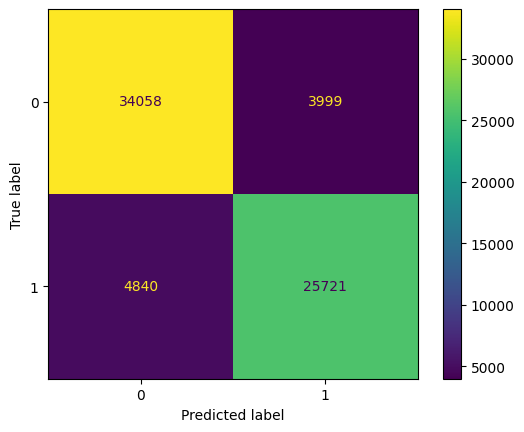

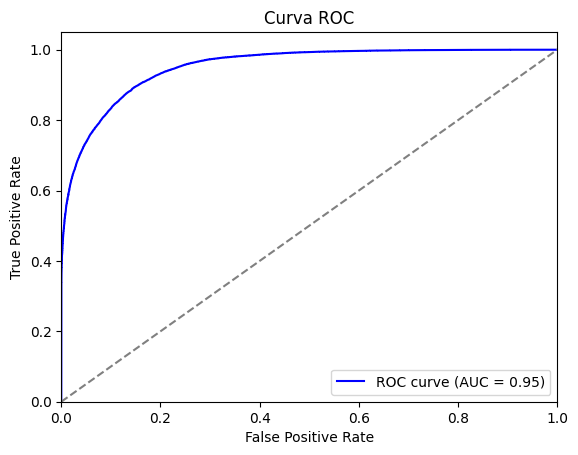

In [25]:
# Avaliar o modelo
test_loss, test_accuracy = model.evaluate([X_test_temp, X_test_fixas], y_test)
print(f'Acurácia no conjunto de teste: {test_accuracy}')


# Fazer as predições nos dados de teste
y_pred_prob = model.predict([X_test_temp, X_test_fixas])

# Converter as probabilidades em classes binárias (0 ou 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Calcular MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

# Calcular precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')


# Gerar as probabilidades para o cálculo da ROC
y_pred_prob = model.predict([X_test_temp, X_test_fixas])

# Calcular o valor da ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular o AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

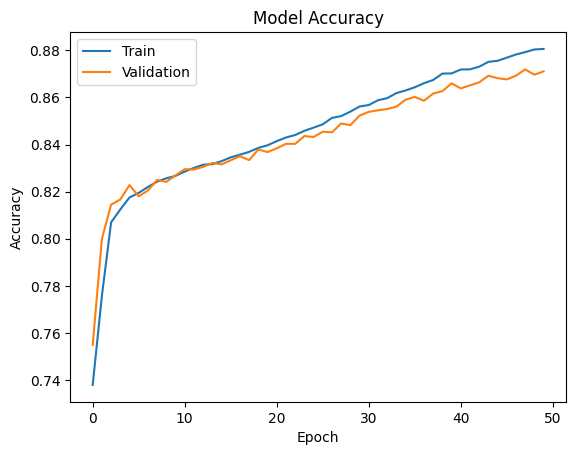

In [29]:
# Curva Aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

### Testando input do modelo

In [26]:
# Exemplo de input próprio para features temporais
input_temporais = np.random.rand(1, 7, 26)  # 1 amostra, 7 passos de tempo, 26 features por passo
print(input_temporais)
# Exemplo de input próprio para features fixas
input_fixas = np.random.rand(1, len(features_fixas))  # 1 amostra, número de features fixas
print(input_fixas)
# Fazer a predição
predicao = model.predict([input_temporais, input_fixas])

# Exibir a predição
print(f"Predição: {predicao[0][0]}")  # A saída será um valor entre 0 e 1


[[[0.28916641 0.88536704 0.0916145  0.64075145 0.86544775 0.15466009
   0.08738372 0.31056558 0.86137106 0.24010031 0.58786799 0.55553858
   0.6576455  0.88302567 0.39598506 0.41069407 0.34568642 0.84082918
   0.58207193 0.54672353 0.17473433 0.68418734 0.02131546 0.14629302
   0.19977042 0.39430645]
  [0.57590739 0.9692992  0.08443501 0.82856309 0.15073515 0.51528041
   0.47191586 0.75145636 0.21171868 0.79681062 0.73414099 0.42215721
   0.83068037 0.51347194 0.48509596 0.95383665 0.82005123 0.67004532
   0.82736075 0.07586634 0.68262888 0.33903469 0.71898486 0.33293626
   0.97902606 0.15319464]
  [0.44751329 0.2763736  0.62762626 0.62314548 0.62675292 0.34045505
   0.11438107 0.24822175 0.80104388 0.16680403 0.80684673 0.72195297
   0.01340511 0.24494961 0.72825191 0.0792817  0.3002049  0.59054866
   0.25636113 0.81236989 0.12142151 0.72041914 0.96345623 0.57587231
   0.56434143 0.87853038]
  [0.4038972  0.08310181 0.56342924 0.26281312 0.33429681 0.10298416
   0.64028475 0.62811183 

In [28]:
# Salvar o modelo treinado em um arquivo HDF5
model.save('/content/drive/Shareddrives/AEGEA/modelo_fraude.h5')  # Caminho onde o arquivo será salvo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Relatório de Avaliação de Modelo: Análise com Métricas, Curva ROC e Matriz de Confusão

**Visão Geral**

Este relatório apresenta uma avaliação detalhada do desempenho do modelo de classificação binária. Ele inclui as principais métricas derivadas da acurácia, coeficiente de correlação de Matthews (MCC), precisão e uma análise da curva de aprendizado observada durante o treinamento. Além disso, a análise da matriz de confusão e da curva ROC oferece uma visão holística sobre o comportamento do modelo.

**Análise das Métricas**

- **Acurácia no conjunto de teste**: 0.8712
- **Coeficiente de Correlação de Matthews (MCC)**: 0.7388
- **Precisão**: 0.8654

Essas métricas indicam que o modelo possui um bom desempenho geral, com uma precisão elevada e um coeficiente de correlação de Matthews que mostra uma correlação forte entre as previsões e os resultados reais.

**Explicando o Coeficiente de Correlação de Matthews (MCC)**

**O que é o MCC?**

O Coeficiente de Correlação de Matthews (MCC) é uma métrica usada para avaliar o desempenho de modelos de classificação binária. Ele leva em consideração todos os quatro valores da matriz de confusão: verdadeiros positivos (VP), verdadeiros negativos (VN), falsos positivos (FP) e falsos negativos (FN).

**Fórmula**

A fórmula do MCC é:

```
MCC = (VP * VN - FP * FN) / √((VP + FP) * (VP + FN) * (VN + FP) * (VN + FN))
```

**Utilidade**

* **Robustez a dados desbalanceados:** O MCC é especialmente útil quando as classes estão desbalanceadas, ou seja, quando uma classe é muito mais frequente do que a outra. Em tais casos, métricas como a acurácia podem ser enganosas, pois um modelo pode obter uma alta acurácia simplesmente prevendo a classe majoritária para todas as amostras. O MCC, por levar em consideração todos os quadrantes da matriz de confusão, é menos sensível a esse problema.

* **Interpretação intuitiva:** O MCC varia de -1 a 1, com os seguintes significados:

    * **MCC = 1:** Classificação perfeita.
    * **MCC = 0:** O modelo não é melhor do que uma escolha aleatória.
    * **MCC = -1:** Classificação completamente errada.

* **Considera todos os aspectos da classificação:** Ao contrário de métricas como precisão e recall, que se concentram em aspectos específicos da classificação (positivos ou negativos), o MCC fornece uma avaliação mais completa do desempenho do modelo, considerando tanto a capacidade de identificar corretamente as amostras positivas quanto as negativas.

* **Matriz de Confusão:** A matriz de confusão fornece uma visão detalhada do comportamento do modelo, revelando a distribuição de verdadeiros positivos (VP), verdadeiros negativos (VN), falsos positivos (FP) e falsos negativos (FN).

    * O alto número de VN e VP reforça a capacidade do modelo de realizar classificações corretas.
    * A presença de FP e FN destaca áreas onde o modelo pode ser otimizado. Os FP indicam uma tendência do modelo a classificar algumas amostras como positivas quando, na verdade, são negativas, o que pode ser problemático em aplicações com alto custo de falsos positivos. Por outro lado, os FN representam amostras positivas que o modelo classificou incorretamente como negativas, o que pode ser crítico em situações onde o custo de falsos negativos é alto.

* **Análise da Curva de Aprendizado**: O gráfico da **Curva de Acurácia** ao longo das épocas de treinamento destaca o progresso do modelo em termos de aprendizado:

 * **Acurácia de Treinamento (linha azul)**: A acurácia no conjunto de treino continua subindo de forma consistente, atingindo cerca de 88,5% após 50 épocas.
 * **Acurácia de Validação (linha laranja)**: A acurácia de validação segue um padrão similar ao da curva de treino, mas estabiliza após 40 épocas, flutuando entre 85% e 86%. Esse padrão sugere que o modelo está generalizando bem, embora haja uma leve diferença entre a performance em treino e validação.

 * **Interpretação:**

  * **Tendência positiva**: Ambas as curvas mostram um aumento contínuo na acurácia, sugerindo que o modelo está aprendendo de forma eficaz.
  * **Estabilização da validação**: A curva de validação se estabiliza após um certo número de épocas, enquanto a curva de treino continua a melhorar. Isso pode indicar um início de **overfitting**, onde o modelo começa a se ajustar muito aos dados de treino e menos aos dados de validação.

*  **Recomendações para a Curva de Aprendizado:**
 * Implementar **early stopping**: Para evitar que o modelo superajuste os dados de treino, uma técnica de early stopping pode ser utilizada, interrompendo o treinamento quando a acurácia de validação não melhorar após um certo número de épocas.
 **Regularização**: A adição de técnicas como dropout ou L2 regularization pode ajudar a reduzir o risco de overfitting e melhorar a generalização.

**Interpretação Holística e Recomendações**

A análise conjunta das métricas, da curva ROC e da matriz de confusão oferece uma visão completa do desempenho do modelo. O modelo demonstra uma excelente capacidade de discriminação entre as classes, com alta precisão e bom desempenho geral. No entanto, a presença de FP e FN indica que há espaço para aprimoramento, especialmente em relação ao equilíbrio entre esses dois tipos de erros, dependendo dos requisitos específicos da aplicação.

Recomenda-se uma análise mais aprofundada do contexto da aplicação e dos custos associados a FP e FN para orientar a otimização do modelo. Algumas estratégias que podem ser consideradas incluem:

* **Ajuste do limiar de decisão:** Se o custo de FP ou FN for particularmente alto, o limiar de decisão pode ser ajustado para favorecer uma classe em detrimento da outra.
* **Balanceamento de classes:** Se houver um desequilíbrio significativo entre as classes no conjunto de dados de treinamento, técnicas de balanceamento de classes podem ser aplicadas para melhorar o desempenho do modelo na classe minoritária.
* **Coleta de mais dados:** Em alguns casos, coletar mais dados, especialmente para a classe minoritária, pode ajudar o modelo a aprender a distinguir melhor entre as classes.
* **Engenharia de recursos:** Criar ou selecionar recursos mais informativos pode melhorar a capacidade do modelo de discriminar entre as classes.
* **Experimentar com diferentes algoritmos:** Se as otimizações anteriores não produzirem resultados satisfatórios, pode ser útil experimentar diferentes algoritmos de aprendizado de máquina para encontrar um que se adapte melhor ao problema em questão.

**Conclusão**

O modelo avaliado apresenta um desempenho promissor na tarefa de classificação, conforme evidenciado pelas métricas, pela curva ROC e pela matriz de confusão. A análise integrada dessas informações permite uma compreensão abrangente das capacidades do modelo, seus pontos fortes e áreas potenciais de aprimoramento. A análise da curva de aprendizado sugere que o modelo está bem ajustado, mas pode se beneficiar de técnicas adicionais para evitar overfitting, sendo possível uma refinação.


# Como fomos além!
- Alta utilidade dos dados externos
- Utilização de Encoding Cíclico
- SMOTE + UNDERSAMPLING
- LSTM por Trimestre
- Utilização da métrica Matthews Correlation Coefficient